In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
from collections import Counter
import seaborn as sns
import pandas as pd
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
IMAGE_DIR = 'image_contest_level_2_validate'
CROP_DIR = 'crop_split_test'

from multiprocessing import Pool, Lock, Manager

# 数据并行预处理

In [2]:
def f(index):
    img = cv2.imread('%s/%d.png'%(IMAGE_DIR, index))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eq = cv2.equalizeHist(gray)
    b = cv2.medianBlur(eq, 9)
    
    m, n = img.shape[:2]
    b2 = cv2.resize(b, (n//4, m//4))

    m1 = cv2.morphologyEx(b2, cv2.MORPH_OPEN, np.ones((7, 40)))
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, np.ones((4, 4)))
    _, bw = cv2.threshold(m2, 127, 255, cv2.THRESH_BINARY_INV)
    
    bw = cv2.resize(bw, (n, m))

    img2, ctrs, hier = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(ctrs) > 3:
        print index
    
    # 微调三个公式
    d = 10
    imgs = []
    sizes = []
    for i, ctr in enumerate(ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        if w*h < 1000:
            continue
        roi = img[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        
        x = b[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        _, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY_INV)
        _, x, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(np.vstack(x))
        roi2 = roi[y:y+h,x:x+w]
        imgs.append(roi2)
        cv2.imwrite('%s/%d_%d.png'%(CROP_DIR, index, i), roi2)
        sizes.append((w, h))
    
    # 连接三个公式
    sizes = np.array(sizes)
    w, h = sizes[:,1].max(), sizes[:,0].sum()+(len(sizes)-1)*2
    img = np.zeros((w, h, 3), dtype=np.uint8)
    x = 0
    for a in imgs[::-1]:
        iw = a.shape[1]
        img[:a.shape[0], x:x+iw] = a
        x += iw + 2
    
    cv2.imwrite('%s/%d.png'%(CROP_DIR, index), img)
    
    return [index, w, h, m, n, len(sizes)]

In [3]:
%%time

try:
    p
except:
    p = Pool(12)

n = 100000
if __name__ == '__main__':
    rs = []
    for r in tqdm(p.imap_unordered(f, range(n)), total=n):
        rs.append(r)

100%|██████████| 100000/100000 [23:46<00:00, 70.12it/s]

CPU times: user 21.4 s, sys: 3.34 s, total: 24.8 s
Wall time: 23min 46s


In [4]:
df = pd.DataFrame(rs, columns=list('iwhmnr'))
df.index = df['i']
df = df.sort_index()
df = df.drop('i', 1)
df.head()

,w,h,m,n,r
i,,,,,
0,59,780,500,3200,3
1,59,731,1000,4000,2
2,60,715,400,2400,3
3,48,763,1000,4000,3
4,65,769,600,2400,3


In [5]:
df[df['r'] > 3]

,w,h,m,n,r
i,,,,,


In [6]:
df.to_csv('r_test.csv', index=None)

# 结果可视化

In [7]:
def disp2(img):
    cv2.imwrite('a.png', img)
    return Image('a.png')


def disp(img, txt=None, first=False):
    global index
    if first:
        index = 1
        plt.figure(figsize=(16, 9))
    else:
        index += 1
    plt.subplot(2, 3, index)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if txt:
        plt.title(txt)

# 技术原理

* [转灰度图](http://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html)
* [二值化](http://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
* [直方图均衡](http://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html)
* [中值滤波](http://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)
* [开运算](http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)
* [轮廓查找](http://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
* [边界矩形](http://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)

参考链接：

* http://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
* http://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
* http://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html
* http://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
* http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
* http://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html
* http://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html

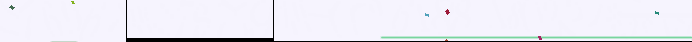

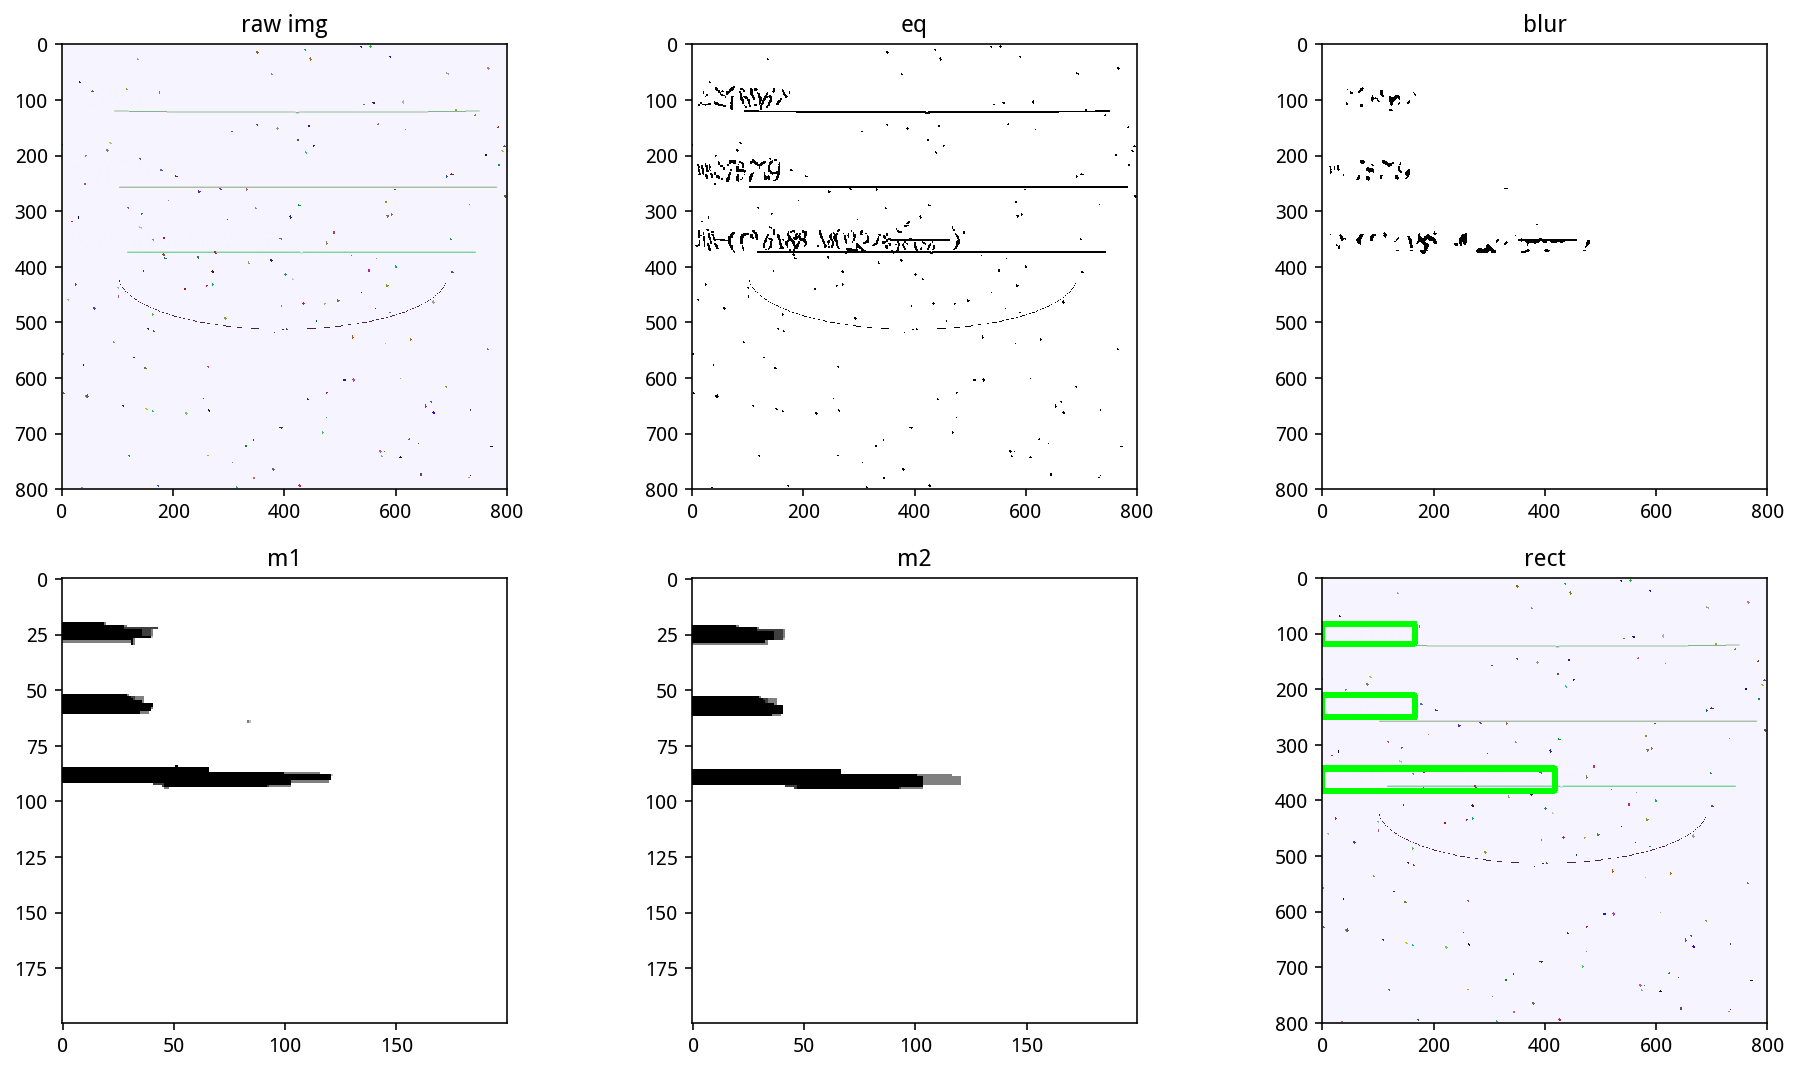

In [8]:
def plot(index):
    global img, gray, b, eq, bw, m1, m2, r, roi
    img = cv2.imread('%s/%d.png'%(IMAGE_DIR, index))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eq = cv2.equalizeHist(gray)
    b = cv2.medianBlur(eq, 9)
    
    m, n = img.shape[:2]
    b2 = cv2.resize(b, (n//4, m//4))

    m1 = cv2.morphologyEx(b2, cv2.MORPH_OPEN, np.ones((7, 40)))
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, np.ones((4, 4)))
    _, bw = cv2.threshold(m2, 127, 255, cv2.THRESH_BINARY_INV)
    
    bw = cv2.resize(bw, (n, m))

    r = img.copy()
    img2, ctrs, hier = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for ctr in ctrs:
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(r, (x, y), (x+w, y+h), (0, 255, 0), 10)
    x, y, w, h = cv2.boundingRect(np.vstack(ctrs))
    
    disp(img, 'raw img', 1)
    disp(eq, 'eq')
    disp(b, 'blur')
    disp(m1, 'm1')
    disp(m2, 'm2')
    disp(r, 'rect')
    
    # 微调三个公式
    d = 10
    imgs = []
    sizes = []
    for i, ctr in enumerate(ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi = img[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        
        x = b[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        _, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY_INV)
        _, x, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(np.vstack(x))
        roi2 = roi[y:y+h,x:x+w]
        imgs.append(roi2)
        sizes.append((w, h))
    
    # 连接三个公式
    sizes = np.array(sizes)
    img = np.zeros((sizes[:,1].max(), sizes[:,0].sum()+len(sizes)-1, 3), dtype=np.uint8)
    x = 0
    for a in imgs[::-1]:
        w = a.shape[1]
        img[:a.shape[0], x:x+w] = a
        x += w + 1
    
    return disp2(img)
    
plot(95170)